# Self-Driving Car Engineer Nanodegree


## Project 5: **Vehicle Detection and Tracking** 
***
### The Goal of this Project
In this project, your goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. The test images and project video are available in the [project repository](https://github.com/udacity/CarND-Vehicle-Detection). There is an [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) in the repository provided as a starting point for your writeup of the project.


### The steps of this project are the following:

#### I - Extract Features
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 

#### II - Build and Train a Classifier
* Train a classifier Linear SVM classifier.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

#### III - Conduct a Sliding Window Search
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

#### IV - Video Implementation
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
#### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  


### Given Images
```
[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4
```

#![alt text][image2]

### I - Extract Features - Histogram of Oriented Gradients (HOG)
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 

#### 1. Read the training images (vehicle and non-vehicle).

In [1]:
# Imports

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

Number of vehicle images:  8792
Number of non-vehicle images:  8968


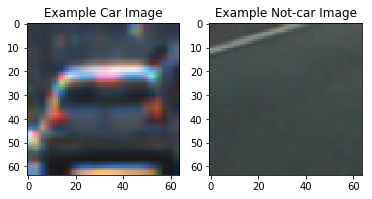

In [2]:
# Read in all the vehicles and non-vehicle images
# Randomly display one example for vehicle and non-vehicle images

path_v = 'project_datasets/vehicles/'
path_nv = 'project_datasets/non-vehicles/'

images_cars = os.listdir(path_v)
images_notcars = os.listdir(path_nv)

cars = []
notcars = []

for image_c in images_cars:
        cars.extend(glob.glob(path_v+image_c+'/*'))
        
for image_nc in images_notcars:
        notcars.extend(glob.glob(path_nv+image_nc+'/*'))
        
print('Number of vehicle images: ', len(cars)) 
print('Number of non-vehicle images: ', len(notcars)) 

# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.title('Example Car Image')
plt.imshow(car_image)
plt.subplot(122)
plt.title('Example Not-car Image')
plt.imshow(notcar_image); #semi-colon to supress unwanted output


#### 2. Extract Histogram of Oriented Gradients (HOG) features from the labeled training set of images.

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False, block_norm='L2-Hys')
        return features, hog_image
    else:
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm='L2-Hys')
        return features
    

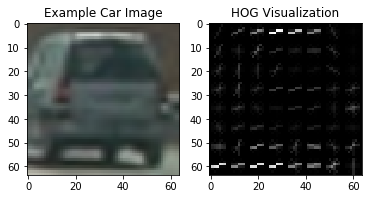

In [4]:
# Test get_hog_features()

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization');


#### 3. Combine Features
Explore different color spaces and try various combinations of  `skimage.hog()` parameters
`orientations`, `pixels_per_cell`, and `cells_per_block`.  

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()

def extract_features(imgs, 
                     cspace='RGB', 
                     spatial_size=(32, 32),
                     hist_bins=32, 
                     hist_range=(0, 256),
                     orient=9, 
                     pix_per_cell=8, 
                     cell_per_block=2, 
                     hog_channel=0):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
                
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Append the new feature vector to the features list
                # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
   
    # Return list of feature vectors
    return features


#### 4. Normalize Features

In [7]:
def normalize(car_features, notcar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    return X, scaled_X

Example using the `YCrCb` color space and HOG parameters 
`orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`.

In [8]:
# Plot an example of raw and scaled features
def plot_image(img1, d1, d2, t1, t2, t3):
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(img1))
    plt.title(t1)
    plt.subplot(132)
    plt.plot(d1)
    plt.title(t2)
    plt.subplot(133)
    plt.plot(d2)
    plt.title(t3)
    fig.tight_layout()

116.34 Seconds to extract HOG features...


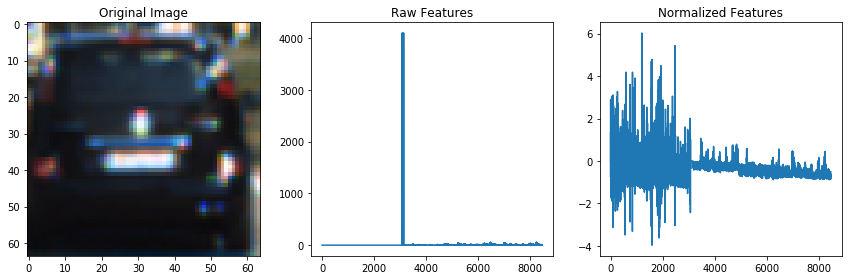

In [9]:
# Test extract_features() 

# Reduce the sample size because HOG features are slow to compute
#sample_size = 100
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins=32
hist_range=(0, 256)                   
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()

car_features = extract_features(cars, 
                     cspace=colorspace, 
                     spatial_size=spatial_size,
                     hist_bins=hist_bins, 
                     hist_range=hist_range,
                     orient=orient, 
                     pix_per_cell=pix_per_cell, 
                     cell_per_block=cell_per_block, 
                     hog_channel=hog_channel)

notcar_features = extract_features(notcars, 
                     cspace=colorspace, 
                     spatial_size=spatial_size,
                     hist_bins=hist_bins, 
                     hist_range=hist_range,
                     orient=orient, 
                     pix_per_cell=pix_per_cell, 
                     cell_per_block=cell_per_block, 
                     hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


if len(car_features) > 0:
    X, scaled_X = normalize(car_features, notcar_features)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    plot_image(cars[car_ind], X[car_ind], scaled_X[car_ind],
                'Original Image', 'Raw Features', 'Normalized Features')
    
else: 
    print('Your function only returns empty feature vectors...')


### II - Build and Train a Classifier

#### 1. Train a classifier using the selected HOG features (and color features if used).

In [10]:
# Train a linear SVM

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
29.36 Seconds to train SVC...
Test Accuracy of SVC =  0.9828
My SVC predicts:  [ 0.  1.  1.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  1.  1.  1.  0.]
0.00133 Seconds to predict 10 labels with SVC


### III -Sliding Window Search

#### 1. Implement a sliding window search.  
- Decide what scales to search?
- How much to overlap windows?
- How to optimize the performance of this classifier?

(Example: searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.)

In [ ]:
# Sliding Window Search
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# draw_boxes function 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



In [ ]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                      
window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)

#### 2. Examples of test images to demonstrate how the pipeline is working.

In [ ]:
# Pipeline 


###  IV - Video Implementation

#### 1. Test pipeline on the entire project video.
(somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

#### 2. Implement some kind of filter for false positives and some method for combining overlapping bounding boxes.
- Record the positions of positive detections in each frame of the video. 
- From the positive detections create a heatmap.
- Thresholded that map to identify vehicle positions.
- Use `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.
- Assume each blob corresponded to a vehicle, construct bounding boxes to cover the area of each blob detected.
- Display result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video.

#### Here are six frames and their corresponding heatmaps:

#### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:

#### Here the resulting bounding boxes are drawn onto the last frame in the series:

#### 3. Here's a [link to my video result](./project_video_result.mp4).

### Discussion

#### Problems / issues aced in implementation of this project.  
- What approach and techniques were used?
- What worked and why?
- Where will the pipeline likely fail?  
- What could be further done to improve and make it more robust?